# Performance test: hyperbolic example

Goal: apply Bayesian Optimisation (BO) and Structured Bayesian Optimisation (SBO) strategies to minimize hemisphere function with pyro and compare the performances of these approaches.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


# Target function

In [3]:
const_x1_min = -10
const_x1_max = 10

const_x2_min = -10
const_x2_max = 10

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def target_func(x):
    """ """

    x1 = x[...,0]
    x2 = x[...,1]
    return 0.3*x1**2 + 2*x2**2

target_lms_np = np.stack(
    (np.array([0.0]), 
     np.array([0.0])), axis=1)

## Helper functions

In [4]:
normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def plot_obj(obj_function):

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contourf(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()
    
def find_best_solution(xmins, target_lms):
    closest_dist = np.inf
    closest_point = None
    
    for xmin in xmins:
        for bh_lm in target_lms:
            dist = np.linalg.norm(xmin-bh_lm)
            if dist < closest_dist: 
                closest_dist = dist
                closest_point = xmin
                
    return closest_point, closest_dist

# GP model

In [5]:
class GPRegressionModule(PyroModule):

    def __init__(self, X, y, kernel):
        """ Defines a PyroModule which wraps GPRegression """
        super().__init__()
        self.X = X
        self.y = y
        self.kernel = kernel
        self.gp = gp.models.GPRegression(X, y, self.kernel)

    @pyro.nn.pyro_method
    def model(self):
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        # sample mu, sigma
        mu, sigma = self.gp(X)
        
        # sample value of y
        pyro.sample('y', dist.Normal(mu, sigma))
    
        # compute expected improvement
        y_min = self.y.min()
        delta = y_min - mu
        EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
                
        pyro.sample('EI', dist.Delta(-EI))

        # return the mean, in case we want to ignore the GP noise for some reason later
        return mu

# Training data

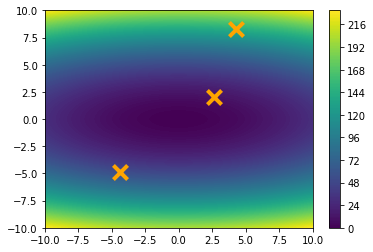

In [6]:
set_random_seed(111)

N_points = 3
X_train = torch.rand(N_points, 2)*20 + torch.FloatTensor([-10, -10])
y_train = target_func(X_train)

plot_obj(target_func)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

# ----

In [7]:
def train(model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the semi-parametric model. """
        
    # Autoguide
    guide = autoguide.AutoMultivariateNormal(model.model)

    # Optimizer
    optimizer = pyro.optim.Adam(adam_params)
    loss = Trace_ELBO()
    svi = SVI(model.model, guide, optimizer, loss)
    
    # do gradient steps
    losses = []
    for _ in range(num_steps):
        losses.append(svi.step())
    
    return losses, guide

In [8]:
def find_a_candidate(model_predict, x_init, constr, num_steps=1000, lr=0.1, num_samples=5):
    """ Finds new candidate """
    
    def transf_values(values, constr, dims, inv_mode=False):
        """ Transforming (un)constrained variables to (un)constrained domain """
        
        x_tmp = ()
        for i in range(dims):
            if inv_mode:
                x_tmp += (transform_to(constr[i]).inv(values[:, i]), )
            else:
                x_tmp += (transform_to(constr[i])(values[:, i]), )
            
        x = torch.stack(x_tmp, dim=1)
        return x
            
    x_dims = x_init.shape[-1]
    
    x_uncon_init = transf_values(x_init, constr, x_dims, inv_mode=True)
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # TODO: at the moment we are using torch optimizer, should we change to pyro?
    #     unconstrained minimiser 
    minimizer = optim.Adam([x_uncon], lr=lr)
    
    def closure():
        minimizer.zero_grad()
        x = transf_values(x_uncon, constr, x_dims)
        
        y = model_predict(x)['EI'].mean(0)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))      
        return y
    
    for _ in range(num_steps):
        minimizer.step(closure)
   
    x = transf_values(x_uncon, constr, x_dims)
    
    return x.detach()

In [9]:
def next_x(model_predict, constr, num_candidates=5, num_steps=1000, lr=0.1, num_samples=5):
    """ Finds the next best candidate on the acquisition function surface """
    
    candidates = []
    values = []
    
    # start with the last step
    x_init = model_predict.model.X[-1:]
    for i in range(num_candidates):

        x_can = find_a_candidate(model_predict, x_init, constr, 
                             num_steps=num_steps, lr=lr, num_samples=num_samples)
        
        y = model_predict(x_can)['EI'].mean(0)
        
        candidates.append(x_can)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x_can[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x_can[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
        
    return candidates[argmin]

In [10]:
def update_posterior(model, obj_function, x_new, num_steps=1000, adam_params={"lr":0.1}):
    
    # evaluate f at new point
    bh_y = obj_function(x_new) 
        
    # incorporate new evaluation
    X = torch.cat([model.X, x_new]) 
    y = torch.cat([model.y, bh_y])
    
    model.X = X
    model.y = y
    
    # TODO: Check if this necessary
    model.gp.set_data(X, y)
    
    losses, guide = train(model, num_steps=num_steps, adam_params=adam_params)
    
    return guide

# ----

# GP BayesOpt Parameters

In [13]:
# Adam parameters
adam_num_steps = 1000
adam_params={"lr": 0.1}

# BayesOpt parameters
num_candidates = 5
bo_steps = 20
num_samples = 1

num_tests = 20

In [ ]:
bo_tests_search_points = []

for test_i in range(num_tests):
#     try:
        print("TEST: ", test_i+1)
        
        pyro.clear_param_store()

        # GP kernel
        kernel = gp.kernels.Matern52(
            input_dim = X_train.shape[1], 
            lengthscale = 10*torch.ones(X_train.shape[1]))

        gp_model = GPRegressionModule(X_train, y_train, kernel)

        gp_model.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([X_train.shape[1]]).to_event())
        gp_model.gp.kernel.variance = PyroSample(dist.Uniform(0, 50))
        gp_model.gp.noise = PyroSample(dist.Uniform(0, 1))

        losses, gp_model_guide = train(gp_model, num_steps=adam_num_steps, adam_params=adam_params)
        
        gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
                                             num_samples=num_samples, return_sites=('EI',))
        
        xmins = np.zeros([bo_steps, 2], np.float32)
        
        for i in range(bo_steps):
            
            x_new = next_x(gp_model_predict, constr, 
                   num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)

            gp_model_guide = update_posterior(gp_model, target_func, x_new, 
                     num_steps=adam_num_steps, adam_params=adam_params)

            gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
                                                         num_samples=num_samples, return_sites=('EI',))
            
            xmins[i] = x_new.detach().numpy()

            closest_point, closest_dist = find_best_solution([xmins[i]], target_lms_np)
            print("  BO STEP: ", i+1, "xmin:", xmins[i], " distance: ", closest_dist)
            
        # saving results for the run
        np.savetxt("pyro_results/pyro_hyperbolic_bo_%d.out" % (test_i), xmins, delimiter=',')
        
        closest_point, closest_dist = find_best_solution(xmins, target_lms_np)
        print("  Best candidate: ", closest_point, " distance: ", closest_dist)

        bo_tests_search_points.append(xmins)
        
#     except:
#         continue

TEST:  1
  BO STEP:  1 xmin: [-9.977856  -0.2809353]  distance:  9.981809888693187
  BO STEP:  2 xmin: [-9.995816 -9.997433]  distance:  14.137361949288579
  BO STEP:  3 xmin: [ 9.994034  -2.8415275]  distance:  10.390139083873947
  BO STEP:  4 xmin: [9.999939  0.8276272]  distance:  10.034129063002771
  BO STEP:  5 xmin: [-9.992079  3.867115]  distance:  10.714299648226774
  BO STEP:  6 xmin: [ 9.9965515 -9.997634 ]  distance:  14.138024135082794
  BO STEP:  7 xmin: [9.997086  3.5149746]  distance:  10.59701685933161
  BO STEP:  8 xmin: [-9.998121  -2.7898684]  distance:  10.380067157715857
  BO STEP:  9 xmin: [-1.0100546  1.1445627]  distance:  1.5265104304467683
  BO STEP:  10 xmin: [-9.999702  9.999699]  distance:  14.14171213219737
  BO STEP:  11 xmin: [-9.99863    1.5856314]  distance:  10.123577436928088
  BO STEP:  12 xmin: [ 6.0681915 -3.4638767]  distance:  6.987230523256834
  BO STEP:  13 xmin: [0.54808044 0.10396099]  distance:  0.5578530819970313
  BO STEP:  14 xmin: [0.29

  BO STEP:  5 xmin: [-2.4307323  0.6001053]  distance:  2.503714365914588
  BO STEP:  6 xmin: [ 9.966633 -9.991212]  distance:  14.11233805157245
  BO STEP:  7 xmin: [-9.99655  4.4951 ]  distance:  10.960699258429306
  BO STEP:  8 xmin: [-9.9942045 -1.70578  ]  distance:  10.138728200297452
  BO STEP:  9 xmin: [9.914198   0.57780457]  distance:  9.931021022408597
  BO STEP:  10 xmin: [ 9.998753 -5.07724 ]  distance:  11.213983206440952
  BO STEP:  11 xmin: [0.51631546 0.83003616]  distance:  0.9775181261145481
  BO STEP:  12 xmin: [ 0.47739887 -0.6492624 ]  distance:  0.8058854658859553
  BO STEP:  13 xmin: [-9.999176  9.999798]  distance:  14.141410030422053
  BO STEP:  14 xmin: [-0.4569044 -2.2783113]  distance:  2.3236746340174994
  BO STEP:  15 xmin: [-7.86821    6.5415974]  distance:  10.232361514902674
  BO STEP:  16 xmin: [4.9498615 6.533947 ]  distance:  8.197169780612246
  BO STEP:  17 xmin: [1.5216494 1.6256084]  distance:  2.226661085726
  BO STEP:  18 xmin: [-7.394918  -7.7

  BO STEP:  9 xmin: [-9.999807  9.99963 ]  distance:  14.14173775803725
  BO STEP:  10 xmin: [0.2132616 0.5759678]  distance:  0.6141818993491884
  BO STEP:  11 xmin: [-1.9359798 -1.627945 ]  distance:  2.5294708342242487
  BO STEP:  12 xmin: [0.26134968 0.05877876]  distance:  0.2678779520037418
  BO STEP:  13 xmin: [0.3169403  0.17489433]  distance:  0.3619933511378714
  BO STEP:  14 xmin: [0.21639252 0.313859  ]  distance:  0.38122589692098097
  BO STEP:  15 xmin: [0.34467793 0.37386322]  distance:  0.5085042570986533
  BO STEP:  16 xmin: [0.16955566 0.17834187]  distance:  0.24607914218763557
  BO STEP:  17 xmin: [0.3006935 0.4010496]  distance:  0.5012558039445888
  BO STEP:  18 xmin: [-9.999071  -2.8260584]  distance:  10.390766540450239
  BO STEP:  19 xmin: [ 6.0623093 -0.9542551]  distance:  6.136953350791946
  BO STEP:  20 xmin: [ 1.0913095 -3.9327264]  distance:  4.081334749011579
  Best candidate:  [0.16955566 0.17834187]  distance:  0.24607914218763557
TEST:  12
  BO STEP: 